# Image Registration

This is the fifth and final script in the processing pipeline for IMC data.

The goal is to register the islet panel and immune panel IMC images. 
This is performed using functions from scikit-image and opencv.

By registration, we will be able to estimate distances between panels in downstream analyses.
For example, the distance of a beta-cell subpopulation on the Islet panel and an immune-cell subpopulation on the Immune panel.
Note: The IMC images are taken from 4 µm consecutive sections.
Hence, cells between panels are expected to be the same cell in around 50 % of the time.

The following steps are performed:

**Global registration**
- Global registration using Phase Cross-Correlation

**Local registraiton**
- Local registration using ICP (Iterative Closest Point).

**QC**:
- The registration is used to perform some QC to delete/edit images.


## **Configuration**

### **Import packages**

In [1]:
import numpy as np
from pathlib import Path
import pickle
import sys
import pandas as pd

import matplotlib.pyplot as plt
from steinbock import io
import seaborn as sns
import cv2 as cv

from skimage.registration import phase_cross_correlation

In [2]:
from helper_functions import pad_images
from helper_functions import icp
from helper_functions import plot_centroids
from helper_functions import write_out_dfs

### **Load directories and panels**

Paths to input and output folders as well as antibody panels were exported by the first script (`01_Preprocessing.ipynb`). Here they are imported again.

In [3]:
print(sys.path)
print(sys.executable)
base_dir = Path("/home/processing/")

['/mnt/T1D_Vol/T1D_preprocessing/processing', '/home/ubuntu/mambaforge/envs/open3d/lib/python39.zip', '/home/ubuntu/mambaforge/envs/open3d/lib/python3.9', '/home/ubuntu/mambaforge/envs/open3d/lib/python3.9/lib-dynload', '', '/home/ubuntu/mambaforge/envs/open3d/lib/python3.9/site-packages']
/home/ubuntu/mambaforge/envs/open3d/bin/python


In [4]:
with open(base_dir / "variables/folders.txt", "rb") as handle:
    folders = pickle.loads(handle.read())
folders

{'raw': PosixPath('/home/processing/raw'),
 'img': PosixPath('/home/processing/img'),
 'seg_cells': PosixPath('/home/processing/seg_cells'),
 'seg_islets': PosixPath('/home/processing/seg_islets'),
 'masks_cells': PosixPath('/home/processing/masks_cells'),
 'masks_islets': PosixPath('/home/processing/masks_islets'),
 'data_cells': PosixPath('/home/processing/data_cells'),
 'data_islets': PosixPath('/home/processing/data_islets'),
 'variables': PosixPath('/home/processing/variables'),
 'data': PosixPath('/home/processing'),
 'git': PosixPath('/home/processing')}

In [5]:
# FIXME: uncomment this for development; delete for actual run.
#folders["img"] = Path("/mnt/T1D_Vol/processing/img")
#folders["data_cells"] = Path("/mnt/T1D_Vol/processing/data_cells")
#folders["seg_cells"] = Path("/mnt/T1D_Vol/processing/seg_cells")
#folders["seg_islets"] = Path("/mnt/T1D_Vol/processing/seg_islets")
#folders["masks_islets"] = Path("/mnt/T1D_Vol/processing/masks_islets")

In [6]:
with open(base_dir / "variables/panels.txt", "rb") as handle:
    panels = pd.read_pickle(handle)

for panel_name, panel in panels.items():
    print(panel_name, "\n", panel.head())
panel_names = list(panels.keys())

Islet 
    channel  metal          name antibody_clone  keep  isletseg  deepcell  \
0        0    Y89       Ghrelin         883622     1       NaN       NaN   
1        1  In113   Histone H3            D1H2     1       NaN       1.0   
2        2  In115        Biotin         1D4-C5     1       NaN       NaN   
6        6  La139  Somatostatin         ICDCLS     1       NaN       NaN   
7        7  Ce140       Insulin        19H4L12     1       NaN       NaN   

   dimred  clustering short_name  
0     1.0         1.0       GHRL  
1     0.0         0.0         H3  
2     1.0         0.0        HBP  
6     1.0         1.0        SST  
7     1.0         1.0        INS  
Immune 
    channel  metal          name antibody_clone  keep  isletseg  deepcell  \
0        0    Y89           MPO            pAb     1       NaN       NaN   
1        1  In113   Histone H3            D1H2     1       NaN       1.0   
2        2  In115           SMA            1A4     1       NaN       NaN   
6        6  

# Prepare Data

First, a dataframe (`image_dfs`) containing paths to all three types of input data is prepared.

Load in:
1) Merged islet segmentation channels (CHGA, SYP)
2) Binary segmentation masks
3) Regionprops-files: contain coordinates, metadata

In [7]:
image_dfs = dict.fromkeys(panel_names)

for pan_idx, panel_name in enumerate(panels):
    image_dfs[panel_name] = pd.DataFrame(columns=["image_name", "img_path", "seg_subdir"])

image_dfs

{'Islet': Empty DataFrame
 Columns: [image_name, img_path, seg_subdir]
 Index: [],
 'Immune': Empty DataFrame
 Columns: [image_name, img_path, seg_subdir]
 Index: []}

In [8]:
measurement = "regionprops"
for pan_idx, panel_name in enumerate(panels):
    print(pan_idx, panel_name)

    #------------------------------------------------------------------------------
    ## Load combined Islet channels (CHGA, SYP) images:
    ## These were used to segment the islets.
    seg_subdir = folders["seg_islets"] / panel_name
    input_images = sorted([x.name for x in Path.iterdir(seg_subdir) if x.name.endswith(".tiff")])
    print("Number of images in", panel_name, "panel:", len(input_images))
    
    for img_path in input_images:
        # Add image metadata to the data frame
        image_name = img_path.replace(".tiff", "")
        image_dfs[panel_name] = pd.concat(
            [image_dfs[panel_name], pd.DataFrame({
                "seg_subdir": seg_subdir,
                "image_name": image_name,
                "img_path": img_path,
                "measurement": "image"},
                index = [len(image_dfs[panel_name].index)])])
    
    #------------------------------------------------------------------------------
    ## Load binary Islet masks:
    seg_subdir = folders["masks_islets"] / panel_name
    input_images = sorted([x.name for x in Path.iterdir(seg_subdir) if x.name.endswith(".tiff")])
    print("Number of images in", panel_name, "panel:", len(input_images))
    
    for img_path in input_images:
        # Add image metadata to the data frame
        image_name = img_path.replace(".tiff", "")
        image_dfs[panel_name] = pd.concat(
            [image_dfs[panel_name], pd.DataFrame({
                "seg_subdir": seg_subdir,
                "image_name": image_name,
                "img_path": img_path,
                "measurement": "bin_mask"},
                index = [len(image_dfs[panel_name].index)])])
    
    #------------------------------------------------------------------------------
    ## Load regionprops measurements:
    ## These contains the centroids of the islets.
    seg_subdir = folders["data_cells"] / panel_name / measurement
    input_csvs = sorted([x.name for x in Path.iterdir(seg_subdir) if x.name.endswith(".csv")])
    print("Number of images in", panel_name, "panel:", len(input_csvs))

    for img_path in input_csvs:
        # Add image metadata to the data frame
        image_name = img_path.replace(".csv", "")
        image_dfs[panel_name] = pd.concat(
            [image_dfs[panel_name], pd.DataFrame({
                "seg_subdir": seg_subdir,
                "image_name": image_name,
                "img_path": img_path,
                "measurement": measurement},
                index = [len(image_dfs[panel_name].index)])])
        
image_dfs["Immune"].head()

0 Islet
Number of images in Islet panel: 7558
Number of images in Islet panel: 7558
Number of images in Islet panel: 7557
1 Immune
Number of images in Immune panel: 7558
Number of images in Immune panel: 7558
Number of images in Immune panel: 7558


,image_name,img_path,seg_subdir,measurement
0,6034_Immune_ROI_001,6034_Immune_ROI_001.tiff,/mnt/T1D_Vol/processing/seg_islets/Immune,image
1,6034_Immune_ROI_002,6034_Immune_ROI_002.tiff,/mnt/T1D_Vol/processing/seg_islets/Immune,image
2,6034_Immune_ROI_003,6034_Immune_ROI_003.tiff,/mnt/T1D_Vol/processing/seg_islets/Immune,image
3,6034_Immune_ROI_004,6034_Immune_ROI_004.tiff,/mnt/T1D_Vol/processing/seg_islets/Immune,image
4,6034_Immune_ROI_005,6034_Immune_ROI_005.tiff,/mnt/T1D_Vol/processing/seg_islets/Immune,image


## **Process Image DF**

Further process the image DF. 

Remove 2 images that are missing in the data_cells folder. 

Finally, merge the 2 dataframes (Immune/Islet) using the image identifier column.

In [9]:
for pan_idx, panel_name in enumerate(panels):
    image_dfs[panel_name].pivot(index = "image_name", columns="measurement", values="img_path")
    image_dfs[panel_name]["case_id"] = image_dfs[panel_name]["image_name"].apply(lambda x: x.split("_")[0]).astype(str)
    image_dfs[panel_name]["ROI"] = image_dfs[panel_name]["image_name"].apply(lambda x: x.split("_")[3]).astype(str) 
    image_dfs[panel_name]["img_id"] = "roi_" + image_dfs[panel_name]["case_id"] + "_" + image_dfs[panel_name]["ROI"]
    image_dfs[panel_name] = image_dfs[panel_name].drop(columns=["ROI", "case_id"])
    # Remove rows with NA values -i.e. missing images.
    image_dfs[panel_name] = image_dfs[panel_name].dropna()

image_dfs["Immune"].head()

,image_name,img_path,seg_subdir,measurement,img_id
0,6034_Immune_ROI_001,6034_Immune_ROI_001.tiff,/mnt/T1D_Vol/processing/seg_islets/Immune,image,roi_6034_001
1,6034_Immune_ROI_002,6034_Immune_ROI_002.tiff,/mnt/T1D_Vol/processing/seg_islets/Immune,image,roi_6034_002
2,6034_Immune_ROI_003,6034_Immune_ROI_003.tiff,/mnt/T1D_Vol/processing/seg_islets/Immune,image,roi_6034_003
3,6034_Immune_ROI_004,6034_Immune_ROI_004.tiff,/mnt/T1D_Vol/processing/seg_islets/Immune,image,roi_6034_004
4,6034_Immune_ROI_005,6034_Immune_ROI_005.tiff,/mnt/T1D_Vol/processing/seg_islets/Immune,image,roi_6034_005


Pivot the dataframe, which introduces hierarchical indexing.

In [10]:
image_dfs["Islet"] = image_dfs["Islet"].pivot(index = "img_id", columns="measurement", values=["img_path", "seg_subdir"])
image_dfs["Immune"] = image_dfs["Immune"].pivot(index = "img_id", columns="measurement", values=["img_path", "seg_subdir"])

df = image_dfs["Islet"].merge(image_dfs["Immune"], on = "img_id", how = "inner", suffixes = ("_Islet", "_Immune"))
df.head()

img_path_Islet                           \
measurement                  bin_mask                    image   
img_id                                                           
roi_6034_001  6034_Islet_ROI_001.tiff  6034_Islet_ROI_001.tiff   
roi_6034_002  6034_Islet_ROI_002.tiff  6034_Islet_ROI_002.tiff   
roi_6034_003  6034_Islet_ROI_003.tiff  6034_Islet_ROI_003.tiff   
roi_6034_004  6034_Islet_ROI_004.tiff  6034_Islet_ROI_004.tiff   
roi_6034_005  6034_Islet_ROI_005.tiff  6034_Islet_ROI_005.tiff   

                                      \
measurement              regionprops   
img_id                                 
roi_6034_001  6034_Islet_ROI_001.csv   
roi_6034_002  6034_Islet_ROI_002.csv   
roi_6034_003  6034_Islet_ROI_003.csv   
roi_6034_004  6034_Islet_ROI_004.csv   
roi_6034_005  6034_Islet_ROI_005.csv   

                                        seg_subdir_Islet  \
measurement                                     bin_mask   
img_id                                                     
roi_6034_001  /mnt/T1D_Vol/processing/masks_islets/Islet   
roi_6034_002  /mnt/T1D_Vol/processing/masks_islets/Islet   
roi_6034_003  /mnt/T1D_Vol/processing/masks_islets/Islet   
roi_6034_004  /mnt/T1D_Vol/processing/masks_islets/Islet   
roi_6034_005  /mnt/T1D_Vol/processing/masks_islets/Islet   

                                                        \
measurement                                      image   
img_id                                                   
roi_6034_001  /mnt/T1D_Vol/processing/seg_islets/Islet   
roi_6034_002  /mnt/T1D_Vol/processing/seg_islets/Islet   
roi_6034_003  /mnt/T1D_Vol/processing/seg_islets/Islet   
roi_6034_004  /mnt/T1D_Vol/processing/seg_islets/Islet   
roi_6034_005  /mnt/T1D_Vol/processing/seg_islets/Islet   

                                                                 \
measurement                                         regionprops   
img_id                                                            
roi_6034_001  /mnt/T1D_Vol/processing/data_cells/Islet/regio...   
roi_6034_002  /mnt/T1D_Vol/processing/data_cells/Islet/regio...   
roi_6034_003  /mnt/T1D_Vol/processing/data_cells/Islet/regio...   
roi_6034_004  /mnt/T1D_Vol/processing/data_cells/Islet/regio...   
roi_6034_005  /mnt/T1D_Vol/processing/data_cells/Islet/regio...   

                       img_path_Immune                            \
measurement                   bin_mask                     image   
img_id                                                             
roi_6034_001  6034_Immune_ROI_001.tiff  6034_Immune_ROI_001.tiff   
roi_6034_002  6034_Immune_ROI_002.tiff  6034_Immune_ROI_002.tiff   
roi_6034_003  6034_Immune_ROI_003.tiff  6034_Immune_ROI_003.tiff   
roi_6034_004  6034_Immune_ROI_004.tiff  6034_Immune_ROI_004.tiff   
roi_6034_005  6034_Immune_ROI_005.tiff  6034_Immune_ROI_005.tiff   

                                       \
measurement               regionprops   
img_id                                  
roi_6034_001  6034_Immune_ROI_001.csv   
roi_6034_002  6034_Immune_ROI_002.csv   
roi_6034_003  6034_Immune_ROI_003.csv   
roi_6034_004  6034_Immune_ROI_004.csv   
roi_6034_005  6034_Immune_ROI_005.csv   

                                        seg_subdir_Immune  \
measurement                                      bin_mask   
img_id                                                      
roi_6034_001  /mnt/T1D_Vol/processing/masks_islets/Immune   
roi_6034_002  /mnt/T1D_Vol/processing/masks_islets/Immune   
roi_6034_003  /mnt/T1D_Vol/processing/masks_islets/Immune   
roi_6034_004  /mnt/T1D_Vol/processing/masks_islets/Immune   
roi_6034_005  /mnt/T1D_Vol/processing/masks_islets/Immune   

                                                         \
measurement                                       image   
img_id                                                    
roi_6034_001  /mnt/T1D_Vol/processing/seg_islets/Immune   
roi_6034_002  /mnt/T1D_Vol/processing/seg_islets/Immune   
roi_6034_003  /mnt/T1D_Vol/proce

Further add the output directories to the image_df.
The following directories are created:
- registered_regionprops -> the transformed coordinates
- inter_panel_neighbors -> nearest neighbors across panels (can be same cell)

In [11]:
# Add output directories for registration and inter-panel neighbors.
for panel_name in panel_names:
    seg_subdir = "seg_subdir_" + panel_name
    img_path = "img_path_" + panel_name

    # Registration subdirectories and paths (output):
    df.loc[:, (img_path, 'registered_regionprops')] = df.loc[:, (img_path, 'regionprops')].values
    df.loc[:, (seg_subdir, 'registered_regionprops')] = folders["data_cells"] / panel_name / "registered_regionprops"

    # Inter-panel neighbor Subdirectories and paths (output):
    df.loc[:, (seg_subdir, 'inter_panel_neighbors')] = folders["data_cells"] / panel_name / "inter_panel_neighbors"
    df.loc[:,(img_path, 'inter_panel_neighbors')] = df.loc[:, (img_path, 'regionprops')].values
    

## Final processing of the dataframe.
df = df.dropna()
df["case_id"] = df["img_path_Islet"]["bin_mask"].str.split("_", expand = True)[0]
df["islet_roi_id"] = df.loc[:, ("img_path_Islet", "bin_mask")].apply(lambda x: x.replace(".tiff", "").replace("ROI_", ""))
df["immune_roi_id"] = df["img_path_Immune"]["bin_mask"].apply(lambda x: x.replace(".tiff", "").replace("ROI_", ""))
df.head()

img_path_Islet                           \
measurement                  bin_mask                    image   
img_id                                                           
roi_6034_001  6034_Islet_ROI_001.tiff  6034_Islet_ROI_001.tiff   
roi_6034_002  6034_Islet_ROI_002.tiff  6034_Islet_ROI_002.tiff   
roi_6034_003  6034_Islet_ROI_003.tiff  6034_Islet_ROI_003.tiff   
roi_6034_004  6034_Islet_ROI_004.tiff  6034_Islet_ROI_004.tiff   
roi_6034_005  6034_Islet_ROI_005.tiff  6034_Islet_ROI_005.tiff   

                                      \
measurement              regionprops   
img_id                                 
roi_6034_001  6034_Islet_ROI_001.csv   
roi_6034_002  6034_Islet_ROI_002.csv   
roi_6034_003  6034_Islet_ROI_003.csv   
roi_6034_004  6034_Islet_ROI_004.csv   
roi_6034_005  6034_Islet_ROI_005.csv   

                                        seg_subdir_Islet  \
measurement                                     bin_mask   
img_id                                                     
roi_6034_001  /mnt/T1D_Vol/processing/masks_islets/Islet   
roi_6034_002  /mnt/T1D_Vol/processing/masks_islets/Islet   
roi_6034_003  /mnt/T1D_Vol/processing/masks_islets/Islet   
roi_6034_004  /mnt/T1D_Vol/processing/masks_islets/Islet   
roi_6034_005  /mnt/T1D_Vol/processing/masks_islets/Islet   

                                                        \
measurement                                      image   
img_id                                                   
roi_6034_001  /mnt/T1D_Vol/processing/seg_islets/Islet   
roi_6034_002  /mnt/T1D_Vol/processing/seg_islets/Islet   
roi_6034_003  /mnt/T1D_Vol/processing/seg_islets/Islet   
roi_6034_004  /mnt/T1D_Vol/processing/seg_islets/Islet   
roi_6034_005  /mnt/T1D_Vol/processing/seg_islets/Islet   

                                                                 \
measurement                                         regionprops   
img_id                                                            
roi_6034_001  /mnt/T1D_Vol/processing/data_cells/Islet/regio...   
roi_6034_002  /mnt/T1D_Vol/processing/data_cells/Islet/regio...   
roi_6034_003  /mnt/T1D_Vol/processing/data_cells/Islet/regio...   
roi_6034_004  /mnt/T1D_Vol/processing/data_cells/Islet/regio...   
roi_6034_005  /mnt/T1D_Vol/processing/data_cells/Islet/regio...   

                       img_path_Immune                            \
measurement                   bin_mask                     image   
img_id                                                             
roi_6034_001  6034_Immune_ROI_001.tiff  6034_Immune_ROI_001.tiff   
roi_6034_002  6034_Immune_ROI_002.tiff  6034_Immune_ROI_002.tiff   
roi_6034_003  6034_Immune_ROI_003.tiff  6034_Immune_ROI_003.tiff   
roi_6034_004  6034_Immune_ROI_004.tiff  6034_Immune_ROI_004.tiff   
roi_6034_005  6034_Immune_ROI_005.tiff  6034_Immune_ROI_005.tiff   

                                       \
measurement               regionprops   
img_id                                  
roi_6034_001  6034_Immune_ROI_001.csv   
roi_6034_002  6034_Immune_ROI_002.csv   
roi_6034_003  6034_Immune_ROI_003.csv   
roi_6034_004  6034_Immune_ROI_004.csv   
roi_6034_005  6034_Immune_ROI_005.csv   

                                        seg_subdir_Immune  ...  \
measurement                                      bin_mask  ...   
img_id                                                     ...   
roi_6034_001  /mnt/T1D_Vol/processing/masks_islets/Immune  ...   
roi_6034_002  /mnt/T1D_Vol/processing/masks_islets/Immune  ...   
roi_6034_003  /mnt/T1D_Vol/processing/masks_islets/Immune  ...   
roi_6034_004  /mnt/T1D_Vol/processing/masks_islets/Immune  ...   
roi_6034_005  /mnt/T1D_Vol/processing/masks_islets/Immune  ...   

                                               seg_subdir_Islet  \
measurement                              registered_regionprops   
img_id                                                            
roi_6034_001  /mnt/T1D_Vol/processing/data_cells/Islet/regis...   
roi_6034_002  /mnt/

## Quality Control:

Acquisitions from case_id `6526` are rotated. Here, helper functions are defined to rotate these images. `

Another QCed acquisition `6209_Islet_ROI_013` will be deleted in the first script of the analysis pipeline (`01_ImportData_cells_{panel}.Rmd`). Here, Islet and Immune panel images do not match.

`6362_Islet_ROI_052` + `6362_Islet_ROI_056` are switched. -> has been fixed upstream (`01_Processing.ipynb`)

### Helper Functions 
Define Helper Functions to rotate the affected images.

In [12]:
def flip_coords(coordinates, y_max):
    rotated_coordinates = [(-y+y_max, x) for x, y in coordinates]
    df_rot = pd.DataFrame(rotated_coordinates)
    return df_rot

# Perform Registration

The Registration between Immune and Islet panel images is performed by first performing global registration and then local registration. 

## Global Registration

Use **phase cross-correlation** to perform rigid transformation (translation only) for global registration.

Given that **a)** the panel-images have been pre-aligned and **b)** that IMC ROIs are small we make the assumption that only translation is sufficient for accurate registration (=`checked`).

For the global registration we use both the **binary islet segmentation images (0/1)** and the **merged islet channel images (CHGA+SYP)** used for the islet segmentation (see `02_IsletSegmentation.ipynb`). 

## Local Registration:

Use **ICP (Iterative Closest Point)** to perform local registration. ICP aligns two point clouds, which are the globally registered cell-centroid coordinates.

We compute the **residual error** (`error_max`) between source and destination point cloud (Islet and Immune coordinates) for both inputs (merged image and binary segmentation mask) and choose the registration with lower residual error.

Note: 
- ICP is used for cloudpoints with minor transformations. Thus, the overall registration depents greatly on the initial pose estimation, i.e. global registration.


### Registration Function:

`df` = Input Image_df

`idx` = Index in the Image_df. One Acquisition is treated at a time.

`sus` = Array to store indices of potentially dangerous acquisition. Used for QC.

`upsample_factor` = Value above 1 to use upsampled matrix-multiple DFT for phase cross-correlation
see (https://scikit-image.org/docs/stable/auto_examples/registration/plot_register_translation.html).

`binary` = Use either the binary islet segmentation mask (=True) or the merged islet channels. 


In [16]:
def register_images(df, idx, sus = [], upsample_factor=1, binary = False, verbose = False):
    #------------------------------------------------------------------------------------------------------------------
    ## Read in the Regionprop files (coordinates)
    case_id = df["case_id"].iloc[idx]
    islet_roi_id = df["islet_roi_id"].iloc[idx]
    immune_roi_id = df["immune_roi_id"].iloc[idx]

    isl_regionprops_file = df["seg_subdir_Islet"]["regionprops"].iloc[idx] / df["img_path_Islet"]["regionprops"].iloc[idx]
    isl_regionprops = pd.read_csv(str(isl_regionprops_file))
    
    imm_regionprops_file =  df["seg_subdir_Immune"]["regionprops"].iloc[idx] / df["img_path_Immune"]["regionprops"].iloc[idx]
    imm_regionprops = pd.read_csv(str(imm_regionprops_file))

    ## Read in the binary masks or the merged Islet channel images (CHGA+SYP).
    if binary:
        isl_img_file = df["seg_subdir_Islet"]["bin_mask"].iloc[idx] / df["img_path_Islet"]["bin_mask"].iloc[idx]
        imm_img_file = df["seg_subdir_Immune"]["bin_mask"].iloc[idx] / df["img_path_Immune"]["bin_mask"].iloc[idx]
    else:
        isl_img_file = df["seg_subdir_Islet"]["image"].iloc[idx] / df["img_path_Islet"]["image"].iloc[idx]
        imm_img_file = df["seg_subdir_Immune"]["image"].iloc[idx] / df["img_path_Immune"]["image"].iloc[idx]
    isl_img = io.read_image(str(isl_img_file))
    imm_img = io.read_image(str(imm_img_file))

    ## Get the original centroids for later plotting.
    isl_regionprops["Panel"] = "Islet"
    imm_regionprops["Panel"] = "Immune"

    isl_regionprops["centroid_1_dx"] = isl_regionprops["centroid-1"]
    isl_regionprops["centroid_0_dy"] = isl_regionprops["centroid-0"]

    ## Flip the coordinates for case_id 6526
    if case_id == "6526":
        df_temp = isl_regionprops[["centroid-1", "centroid-0"]].to_numpy()
        y_max = max(df_temp[:,1])
        df_out = flip_coords(df_temp, y_max)
        isl_regionprops["centroid_1_dx"] = df_out[0]
        isl_regionprops["centroid_0_dy"] = df_out[1]

    imm_regionprops["centroid_1_dx"] = imm_regionprops["centroid-1"]
    imm_regionprops["centroid_0_dy"] = imm_regionprops["centroid-0"]

    df_regionprops = pd.concat([isl_regionprops, imm_regionprops], axis=0)
    df_original = df_regionprops.assign(panel_islet_parent=df_regionprops["Panel"] + "_" + df_regionprops["islet_parent"].astype(str))
    #------------------------------------------------------------------------------------------------------------------
    ## Pad the images.
    isl_img = isl_img[0,:,:]
    imm_img = imm_img[0,:,:]

    ## Flip the images by 270° for case_id 6526
    if case_id == "6526":
        isl_img = np.rot90(isl_img, k = 3)
        if verbose:
            display("Flipping images")

    ## uncomment for QC:
    #if (isl_img.shape[0] > imm_img.shape[0]) or (isl_img.shape[1] > imm_img.shape[1]):
    #    print("Islet image is larger than the Immune image in at least 1 dimension")
    #    print(f"Isl image: {isl_img.shape}")
    #    print(f"Imm image: {imm_img.shape}")
    #    sus.append(idx)

    isl_img = (isl_img * 255).astype('uint8')
    imm_img = (imm_img * 255).astype('uint8')

    # Pad the smaller image and mask, to make sure both images/masks have the same size
    isl_padded, imm_padded, isl_off, imm_off = pad_images(isl_img, imm_img, (0))
    
    # isl_off = (offset_y1, offset_y1+y1, offset_x1, offset_x1+x1)
    # Translate the x,y-coordinates by the image offsets introduced by the padding
    isl_regionprops["centroid_1_dx"] = isl_regionprops["centroid_1_dx"] + isl_off[2]
    isl_regionprops["centroid_0_dy"] = isl_regionprops["centroid_0_dy"] + isl_off[0]

    imm_regionprops["centroid_1_dx"] = imm_regionprops["centroid_1_dx"] + imm_off[2]
    imm_regionprops["centroid_0_dy"] = imm_regionprops["centroid_0_dy"] + imm_off[0]

    df_padded = pd.concat([isl_regionprops, imm_regionprops], axis=0)
    df_padded = df_padded.assign(panel_islet_parent=df_padded["Panel"] + "_" + df_padded["islet_parent"].astype(str))
    #------------------------------------------------------------------------------------------------------------------
    ## Perform Global Registration using phase cross-correlation with subpixel accuracy (upsample-factor)
    shift, glob_error, diffphase = phase_cross_correlation(isl_padded, imm_padded, upsample_factor=upsample_factor)  

    ## Warp
    dx = -shift[1]
    dy = -shift[0]
    affine_matrix = np.array([[1, 0, dx], [0, 1, dy]])
    if verbose:
        display("Global Registration: ")
        display(f"Translate the padded Islet image by dx = {dx}, dy = {dy} to align it with the padded Immune image")

    # Apply the translation to the Islet image -> This is the globally registered image!
    isl_img_reg_global = cv.warpAffine(isl_padded, affine_matrix, (isl_padded.shape[1], isl_padded.shape[0]))

    # Apply the registration to the padded coordinates. 
    isl_regionprops["centroid_1_dx"] = isl_regionprops["centroid_1_dx"] + dx 
    isl_regionprops["centroid_0_dy"] = isl_regionprops["centroid_0_dy"] + dy 

    df_pre_icp = pd.concat([isl_regionprops, imm_regionprops], axis=0)
    df_pre_icp = df_pre_icp.assign(panel_islet_parent=df_pre_icp["Panel"] + "_" + df_pre_icp["islet_parent"].astype(str))
    #------------------------------------------------------------------------------------------------------------------
    ## Perform ICP
    a = isl_regionprops[['centroid_1_dx', 'centroid_0_dy']].T.to_numpy()
    b = imm_regionprops[['centroid_1_dx', 'centroid_0_dy']].T.to_numpy()

    # ICP converges very rapidly, usually in first 5 iterations.
    T_opt, error_max, indices_opt = icp(a, b, max_iter = 20)

    ## Get the indices of the Immune cells that are closest to the Islet cells.
    opt_ind = indices_opt.squeeze().astype(int)
    imm_keys = imm_regionprops.iloc[opt_ind, :]["Object"].to_list()
    d = {'Object_Islet': isl_regionprops["Object"].tolist(), 'Object_Immune': imm_keys}
    inter_panel_neighbors = pd.DataFrame(d)
    inter_panel_neighbors["islet_roi_id"] = islet_roi_id
    inter_panel_neighbors["immune_roi_id"] = immune_roi_id

    ## Apply the transformation to the Islet Point Cloud -> These are the corrected Islet COORDINATES!
    src = np.array([a.T], copy=True).astype(np.float32)
    coord_icp = cv.transform(src, T_opt[0:2,:])
    
    ## Apply the transformation to the globally registered Islet image -> This is the corrected Islet IMAGE!
    isl_img_reg_icp = cv.warpAffine(isl_img_reg_global, T_opt[0:2,:], (isl_img_reg_global.shape[1], isl_img_reg_global.shape[0]))

    isl_regionprops = isl_regionprops.assign(centroid_1_dx = coord_icp[0,:,0], centroid_0_dy = coord_icp[0, :, 1])
    isl_regionprops["Panel"] = "Islet"

    # These are the corrected coordinates for both Panels.
    df_post_icp = pd.concat([isl_regionprops, imm_regionprops], axis=0)
    df_post_icp = df_post_icp.assign(panel_islet_parent=df_post_icp["Panel"] + "_" + df_post_icp["islet_parent"].astype(str))
    
    # could also return df_padded, T_opt, 
    return df_original, df_padded, df_pre_icp, df_post_icp, inter_panel_neighbors, indices_opt, isl_img, isl_img_reg_global, isl_img_reg_icp, imm_img, error_max

## Perform Registration and save output.

Iterate through all images perform the registration and write the outputs to csvs.

After Registration we obtain:
- New set of cell-centroid coordiantes for the Islet and Immune panel (`df_post_icp`).
- Inter panel neighbors (`inter_panel_neighbors`)
We have to write them out to .csv.

### Create Output Directories

First, create new output directories:
- Registered cell-centroid coordinates: `data_cells/{panel}/registered_regionprops`
- Inter-panel neighbors: `data_cells/{panel}/inter_panel_neighbors`.

In [14]:
# Cell data
measurements = ["inter_panel_neighbors", "registered_regionprops"]

for panel_name in panel_names:
    output_dir_cells = folders["data_cells"] / panel_name
    output_dir_cells.mkdir(exist_ok=True)
    
    for meas_type in measurements:
        meas_dir_cells = output_dir_cells / meas_type
        meas_dir_cells.mkdir(exist_ok=True)

In [17]:
## For QC: Store the residual errors and suspicious images for QC.
bin_arr = []; full_arr = []; idx_arr = []; sus = []

## Iterate through all images.
for idx in range(len(df)):
    idx_arr.append(idx)

    ## Register the binary segmentation masks.
    b_df_original, b_df_padded, b_df_pre_icp, b_df_post_icp, b_inter_panel_neighbors, b_indices_opt, b_isl_img, b_isl_img_reg_global, b_isl_img_reg_icp, b_imm_img, b_error_max = register_images(df, idx, sus = sus, upsample_factor=10, binary= True)
    bin_arr.append(b_error_max)

    ## Register the merged islet channel images (CHGA+SYP).
    df_original, df_padded, df_pre_icp, df_post_icp, inter_panel_neighbors, f_indices_opt, isl_img, isl_img_reg_global, isl_img_reg_icp, imm_img, error_max = register_images(df, idx, sus = sus, upsample_factor=10, binary= False)
    full_arr.append(error_max)
    
    # Choose the registration with lower residual error.
    if (b_error_max < error_max):
        lower_error = b_error_max
        indices_opt = b_indices_opt
        inter_panel_neighbors = b_inter_panel_neighbors
        df_original = b_df_original
        df_padded = b_df_padded
        df_pre_icp = b_df_pre_icp
        df_post_icp = b_df_post_icp
        isl_img_reg_global = b_isl_img_reg_global
        isl_img_reg_icp = b_isl_img_reg_icp
        imm_img = b_imm_img
        isl_img = b_isl_img
    else:
        lower_error = error_max  
    
    ## Very high error is often indicative of problematic alignment.
    ## Could think of normalizing this by the number of cells in the image.
    ## Just for QC.
    if lower_error > 1e6:
        sus.append(idx)
    
    #------------------------------------------------------------------------------------------------------------------
    ## Save the registered images.
    write_out_dfs(df, panel_names, idx, df_post_icp, inter_panel_neighbors)

/mnt/T1D_Vol/processing/data_cells/Islet/registered_regionprops/6034_Islet_ROI_001.csv
/mnt/T1D_Vol/processing/data_cells/Islet/inter_panel_neighbors/6034_Islet_ROI_001.csv
/mnt/T1D_Vol/processing/data_cells/Immune/registered_regionprops/6034_Immune_ROI_001.csv
/mnt/T1D_Vol/processing/data_cells/Immune/inter_panel_neighbors/6034_Immune_ROI_001.csv
/mnt/T1D_Vol/processing/data_cells/Islet/registered_regionprops/6034_Islet_ROI_002.csv
/mnt/T1D_Vol/processing/data_cells/Islet/inter_panel_neighbors/6034_Islet_ROI_002.csv
/mnt/T1D_Vol/processing/data_cells/Immune/registered_regionprops/6034_Immune_ROI_002.csv
/mnt/T1D_Vol/processing/data_cells/Immune/inter_panel_neighbors/6034_Immune_ROI_002.csv
/mnt/T1D_Vol/processing/data_cells/Islet/registered_regionprops/6034_Islet_ROI_003.csv
/mnt/T1D_Vol/processing/data_cells/Islet/inter_panel_neighbors/6034_Islet_ROI_003.csv
/mnt/T1D_Vol/processing/data_cells/Immune/registered_regionprops/6034_Immune_ROI_003.csv
/mnt/T1D_Vol/processing/data_cells/Imm

KeyboardInterrupt: 

In [73]:
## Make Dataframe:
df_error = pd.DataFrame({"idx": idx_arr, "binary": bin_arr, "full": full_arr})
df_error.astype({"idx": int, "binary": int, "full": int})

sus = np.unique(sus)
print(f"Number of suspect images: {len(sus)}")
sus

## Select images where sus matches the idx.
df_error_sus = df_error[df_error["idx"].isin(sus)]
display(len(df_error_sus))
display(df_error_sus)
display(df_error)

NameError: name 'idx_arr' is not defined

# Plot images for QC:

Select a random image and plot its registraiton.

In [18]:
## Select random image.
# idx = 2423
idx = np.random.randint(0, len(df))
display(f"Select random image: {idx}")

b_df_original, b_df_padded, b_df_pre_icp, b_df_post_icp, b_inter_panel_neighbors, b_indices_opt, b_isl_img_reg_global, b_isl_img_reg_icp, b_imm_img, b_isl_img, b_error_max = register_images(df, idx, upsample_factor=10, binary= True)

df_original, df_padded, df_pre_icp, df_post_icp, inter_panel_neighbors, indices_opt, isl_img_reg_global, isl_img_reg_icp, imm_img, isl_img, error_max = register_images(df, idx, upsample_factor=10, binary= False)

# Choose the one with the lower error.
if (b_error_max < error_max):
    lower_error = b_error_max
    indices_opt = b_indices_opt
    inter_panel_neighbors = b_inter_panel_neighbors
    df_original = b_df_original
    df_padded = b_df_padded
    df_pre_icp = b_df_pre_icp
    df_post_icp = b_df_post_icp
    isl_img_reg_global = b_isl_img_reg_global
    isl_img_reg_icp = b_isl_img_reg_icp
    imm_img = b_imm_img
    isl_img = b_isl_img
else:
    lower_error = error_max  

'Select random image: 233'

### Check Global Registration Visually

Use the returned dataframes containing the coordinates to observe the registration.

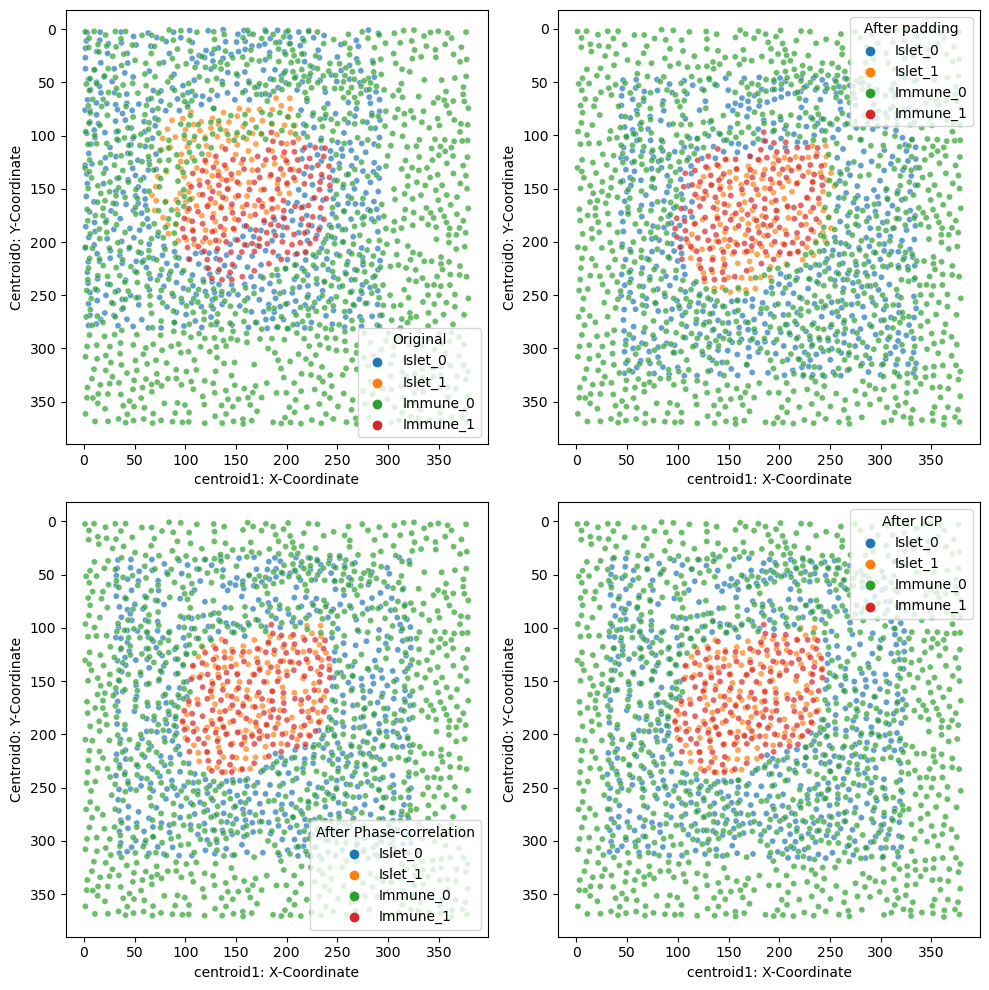

In [22]:
# Subplot 1
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)
fig, axes = plt.subplots(2, 2, figsize=(10, 10))

# Plot all point clouds.
plot_centroids(axes[0, 0], df_original, "Original")
plot_centroids(axes[0, 1], df_padded, title="After padding")
# Plot corrected_img to axes[0,2]
plot_centroids(axes[1, 0], df_pre_icp, "After Phase-correlation")
plot_centroids(axes[1, 1], df_post_icp, "After ICP")

plt.tight_layout()
plt.show()

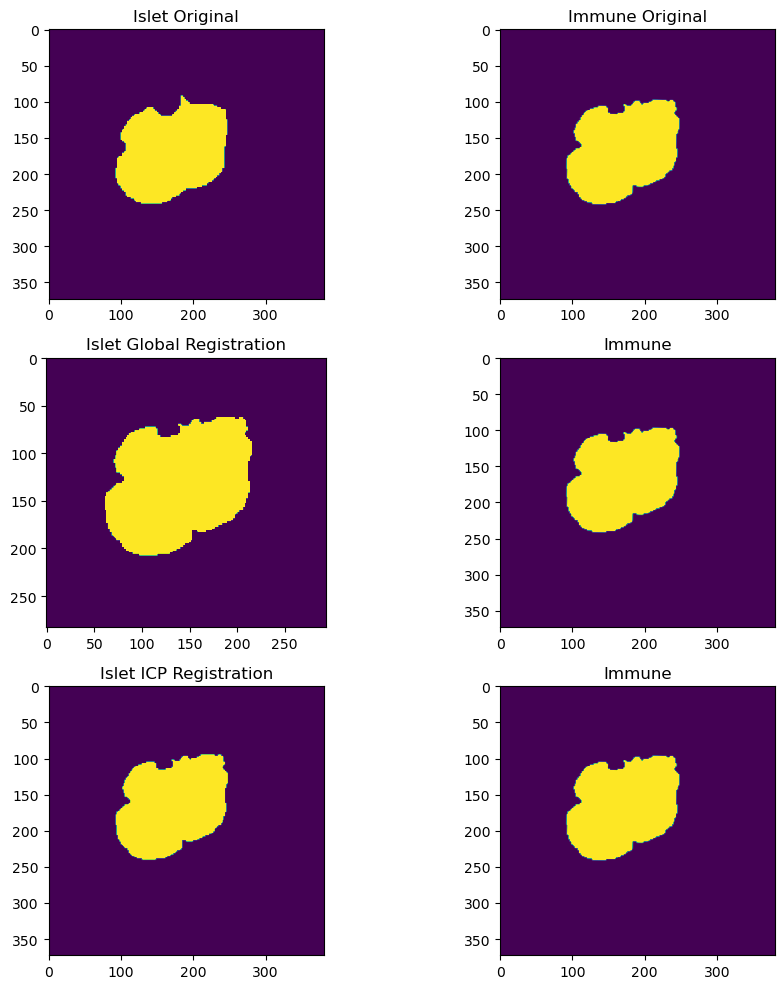

In [23]:
## Plot the registered images.
fig, axes = plt.subplots(3, 2, figsize=(10, 10))

# First row: Original images
axes[0, 0].imshow(isl_img, vmin=0, vmax=150)
axes[0, 0].set_title("Islet Original")
axes[0, 1].imshow(imm_img, vmin=0, vmax=150)
axes[0, 1].set_title("Immune Original")

# Second row: Globally registered images
axes[1, 0].imshow(isl_img_reg_global, vmin=0, vmax=150)
axes[1, 0].set_title("Islet Global Registration")
axes[1, 1].imshow(imm_img, vmin=0, vmax=150)
axes[1, 1].set_title("Immune")

# Third row: ICP registered images
axes[2, 0].imshow(isl_img_reg_icp, vmin=0, vmax=150)
axes[2, 0].set_title("Islet ICP Registration")
axes[2, 1].imshow(imm_img, vmin=0, vmax=150)
axes[2, 1].set_title("Immune")

plt.tight_layout()
plt.show()

In [ ]:
# Use idx = 5405 as image for edge case (negative coordinates after translation)

In [ ]:
## Write success log-message to 04_Measurements.out
base_dir = Path("/home/processing/")
with open(base_dir / "txt_output" / "05_ImageRegistration.out", "w") as f:
    f.write("05_ImageRegistration.py completed successfully!")